#### Objective is to predict the demand for bikes using relevant inputs from the data set

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading and viewing the data
bike_data = pd.read_csv("day.csv")
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# Information regarding the data
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### From the above data we can see that there are no missing values in the dataset

#### Listing down the set of variables
##### a. Ordered categorical
1. year
##### b. Unordered categorical
1. holiday
2. working day
3. weathersit
##### c. Numerical
1. atemp
2. hum
3. windspeed
##### d. Cyclic variables
1. season 
2. weekday


In [5]:

ordered_cat = ["yr"] # ordered categorical columns

unordered_cat = ["holiday","workingday","weathersit"] # unordered categorical columns

num_columns = ["atemp","hum","windspeed"] # numerical columns


In [6]:
# Class for EDA analysis
class EDA:

    def box_plot(self,data,feat):
        plt.figure(figsize=(15,10))
        plt.boxplot(bike_data[feat],labels=feat)
        plt.xlabel("Variable",fontsize=12)
        plt.ylabel("Value",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()  

    def box_plot_cat(self,data,feat):
        plt.figure(figsize=(15,10))
        sns.boxplot(x=feat,y="cnt",data=data)
        plt.xlabel(feat,fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show() 
    
    def detect_outliers(self,data):
        quantiles = data[num_columns].quantile([0.25,0.75])
        for i in num_columns:
            iqr = quantiles.loc[0.75,i]- quantiles.loc[0.25,i]
            lower_range = quantiles.loc[0.25,i] - 1.5*iqr
            upper_range = quantiles.loc[0.75,i] + 1.5*iqr
            outliers = data[(data[i]<lower_range) | (data[i]>upper_range)][i]
            print("Number of outliers in column ",i," are ",len(outliers))

    def remove_outliers(self,data):
        quantiles = data[num_columns].quantile([0.25,0.75])
        for i in num_columns:
            iqr = quantiles.loc[0.75,i]- quantiles.loc[0.25,i]
            lower_range = quantiles.loc[0.25,i] - 1.5*iqr
            upper_range = quantiles.loc[0.75,i] + 1.5*iqr
            outliers = data[(data[i]<lower_range) | (data[i]>upper_range)][i]
            if len(outliers)>0:
                print("Removing ", len(outliers), " outliers in column ",i)
                data = data[(data[i]>lower_range) & (data[i]<upper_range)]
        print("The number of data points after removing outliers are: ",len(data))
        return data

    def plot_corr(self,data):
        corr_mat = data.corr()
        plt.figure(figsize=(20,20))
        blue_map  = sns.color_palette("Blues", as_cmap=True)
        sns.heatmap(corr_mat,cmap=blue_map,annot=True)
        plt.show()

    def plot_scatter(self,data):
        for i in num_columns:
            plt.figure(figsize=(15,10))
            plt.scatter(data[i],data["cnt"])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("cnt",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    def plot_scatter_with_removed(self,data,feature_name,removed_points):
        plt.figure(figsize=(15,10))
        plt.scatter(data[feature_name],data["cnt"])
        plt.scatter(removed_points[:,0],removed_points[:,1],color="red",linewidths=2)
        plt.xlabel(feature_name,fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(["Points considered","Points removed"],fontsize=14)
        plt.show()  

    def plot_bar(self,data,features):
        feat_map_dict = {"yr":["2018","2019"],"weekday":["0","1","2","3","4","5","6"],"holiday":["0","1"],"workingday":["0","1"],"weathersit":["1","2","3"],"season":["spring","summer","fall","winter"]}
        for i in features:
            plt.figure(figsize=(15,10))
            axes = sns.barplot(x=i,y="cnt",data=data,estimator=sum,ci=None)
            axes.set_xticklabels(feat_map_dict[i])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("Sum of cnt",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    

# From the data dictionary
    1) It can be inferred that instant can be dropped as it is just a record number
    2) dteday can be dropped as information is already present in year and month
    3) casual and registered can be dropped as they are not available before hand 



In [7]:
bike_data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)

In [8]:
# Displaying statistical information of the data
bike_data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


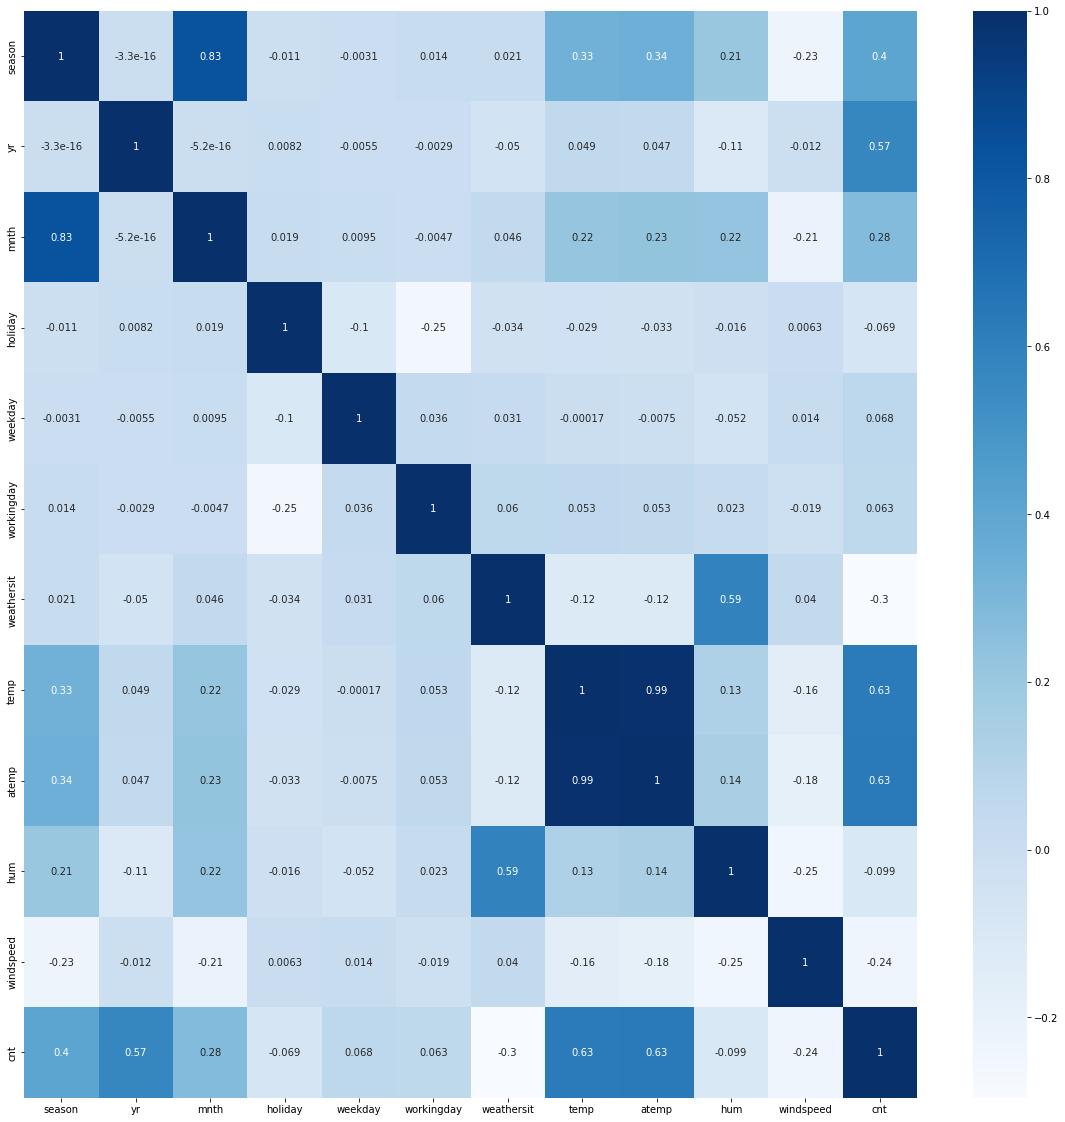

In [9]:
# Exploratory data analysis
eda = EDA()
eda.plot_corr(bike_data)

# From the heatmap, it can be inferred that 
1) temp and atemp are highly correlated. So one of them can be dropped as they are dependent on each other
2) Bikes demand is mostly dependant on atemp,year,season
3) Dropping temp as atemp is more relevant because it is the temperature that the customer feels 
4) It can be seen that even season and month are coorelated as they are dependant i.e you can predict the season from the month of the year
5) Retaining season and dropping month as season is highly corelated to target variable as compared to month


In [10]:
bike_data.drop(["temp","mnth"],axis=1,inplace=True)

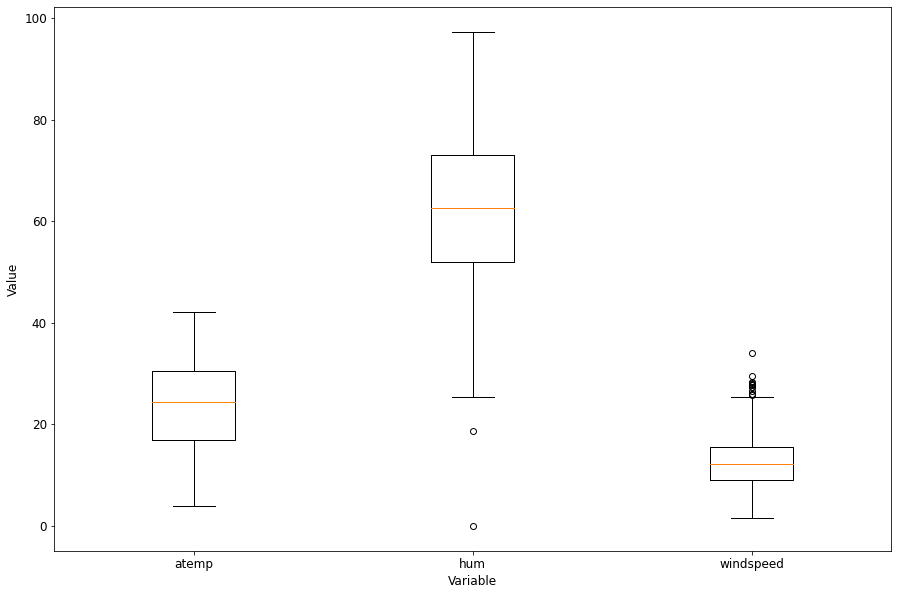

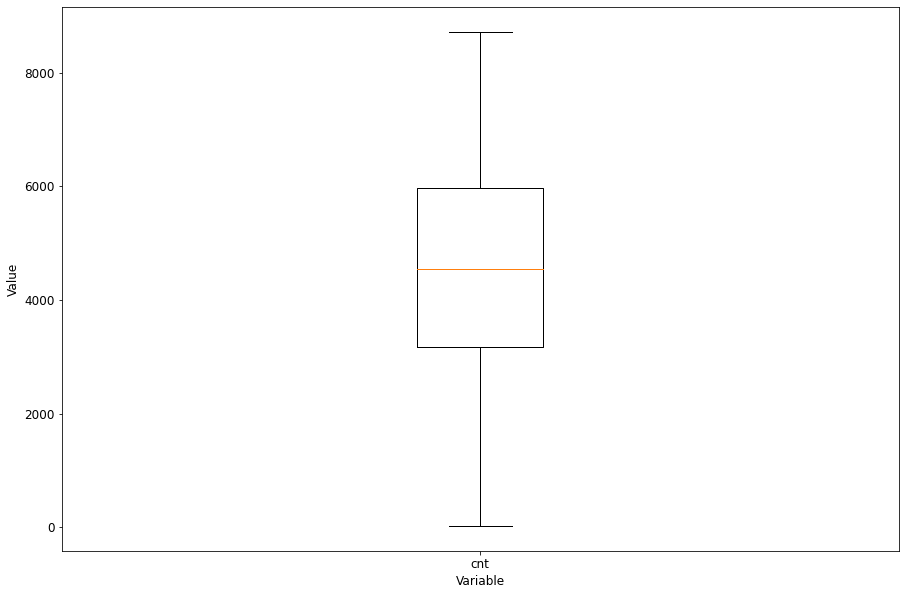

In [11]:
# Plotting box plot to detect outliers - univariate
eda.box_plot(bike_data,num_columns)
eda.box_plot(bike_data,["cnt"])

In [12]:
# It can be seen that variables hum and windspeed have outliers as per the standard outlier definition (univariate)
# No outliers are found in the target variable
# Checking the number of outliers
eda.detect_outliers(bike_data)

Number of outliers in column  atemp  are  0
Number of outliers in column  hum  are  2
Number of outliers in column  windspeed  are  13


#### In linear regression, the outliers are removed based on both input and target variables
#### So neglecting the outliers found from univariate analysis

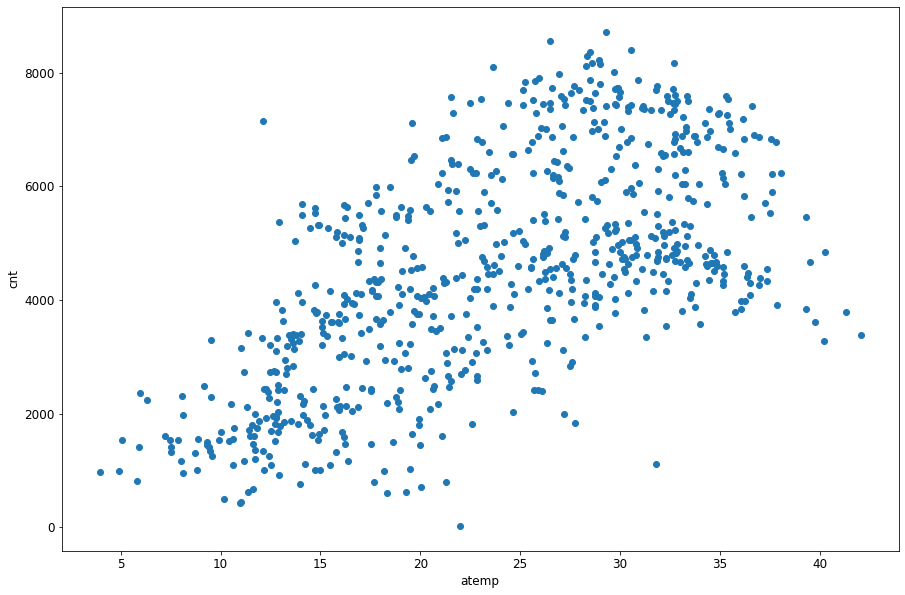

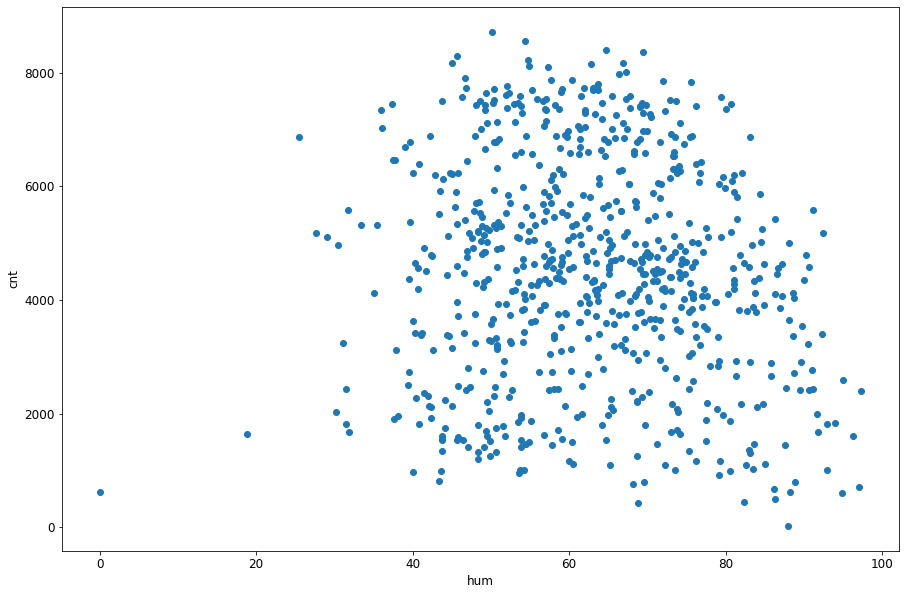

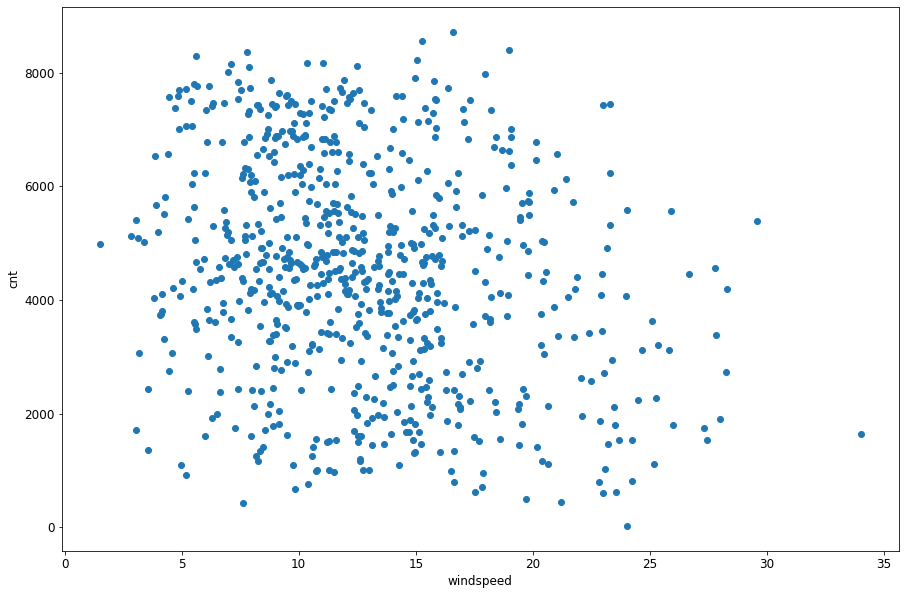

In [13]:
# Plotting scatter plot wrt target variable to detect outliers
eda.plot_scatter(bike_data)

In [14]:
# From the scatter plot it can be seen that some kind of positive linear relationship exists between atemp and cnt
# This was also observed from heatmap where the correlation coefficient was 0.63

In [15]:
# There are some points in the scatter plot which are outliers
# Removing such points manually
removed_points = {"atemp":np.array([(12.12,7148),(31.77,1115),(21.97,22),(41.31,3784),(42.04,3387)]),"hum":np.array([(0,623),(18.79,1635),(25.41,6857)]),"windspeed":np.array([(34,1635),(29.58,5382)])}

In [16]:
# Removing outliers based on scatter plot cnt vs atemp
for i in removed_points.keys():
    bike_data = bike_data[~(bike_data["cnt"].isin (removed_points[i][:,1]))]

print("The number of points remaining after removing the outliers are ",len(bike_data))

The number of points remaining after removing the outliers are  720


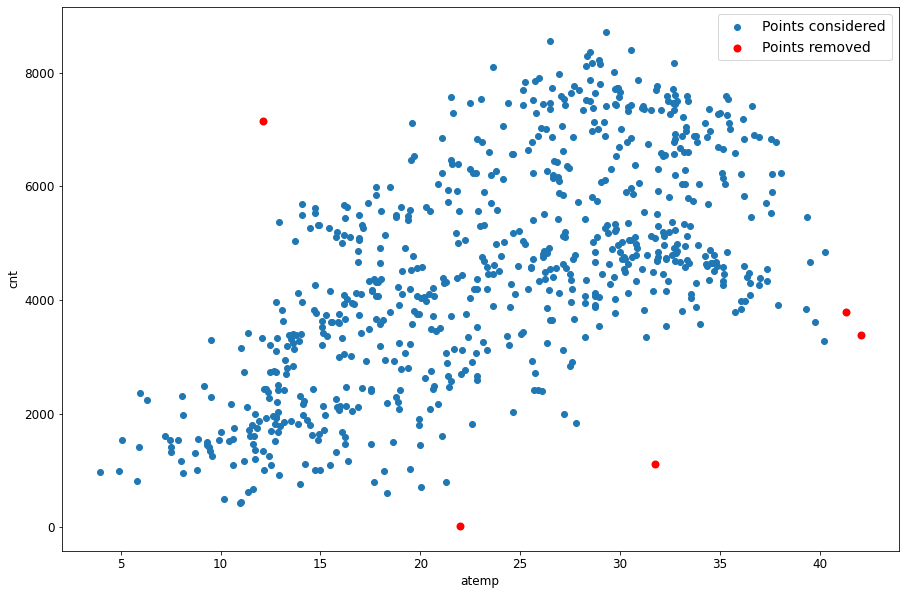

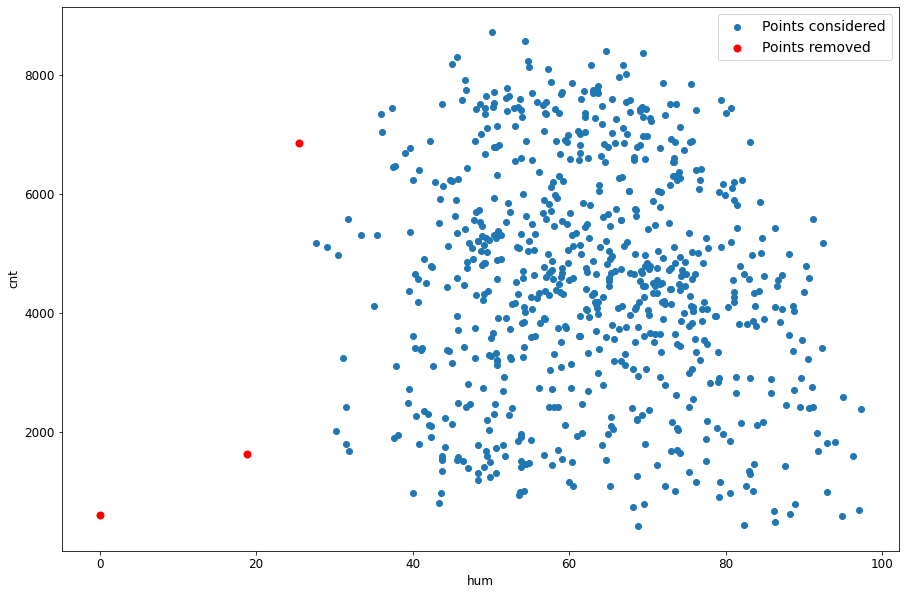

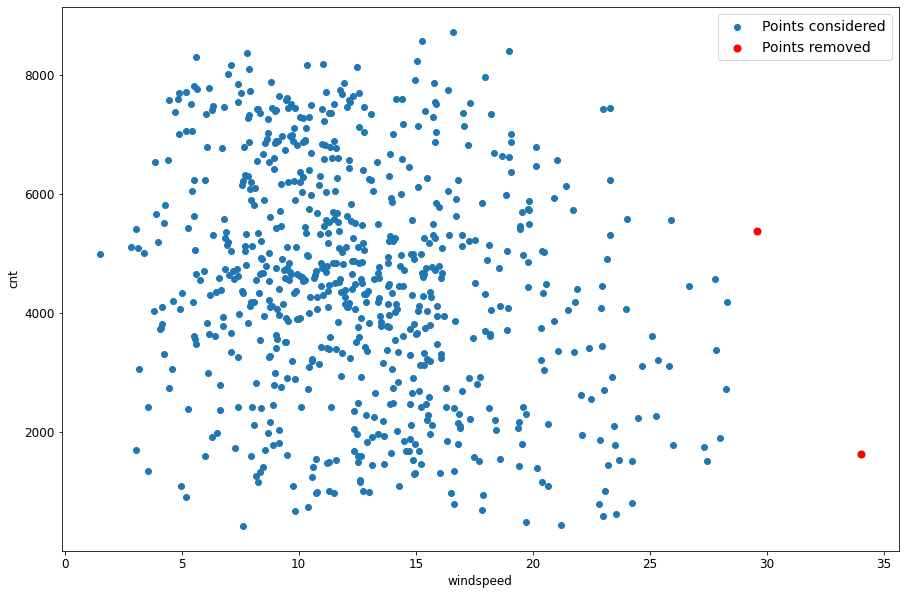

In [17]:
# Highlighting the points that are removed
for i in removed_points.keys():
    eda.plot_scatter_with_removed(bike_data,i,removed_points[i])

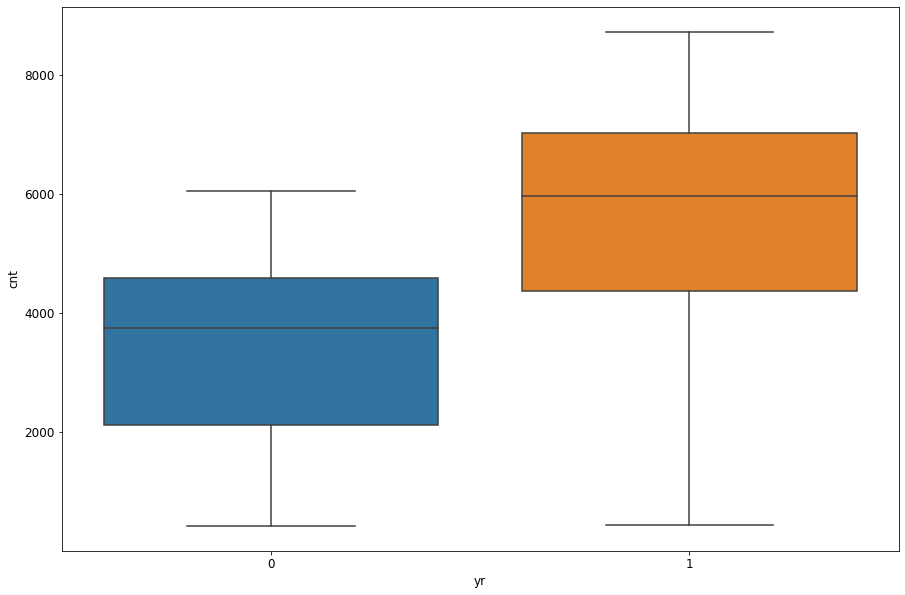

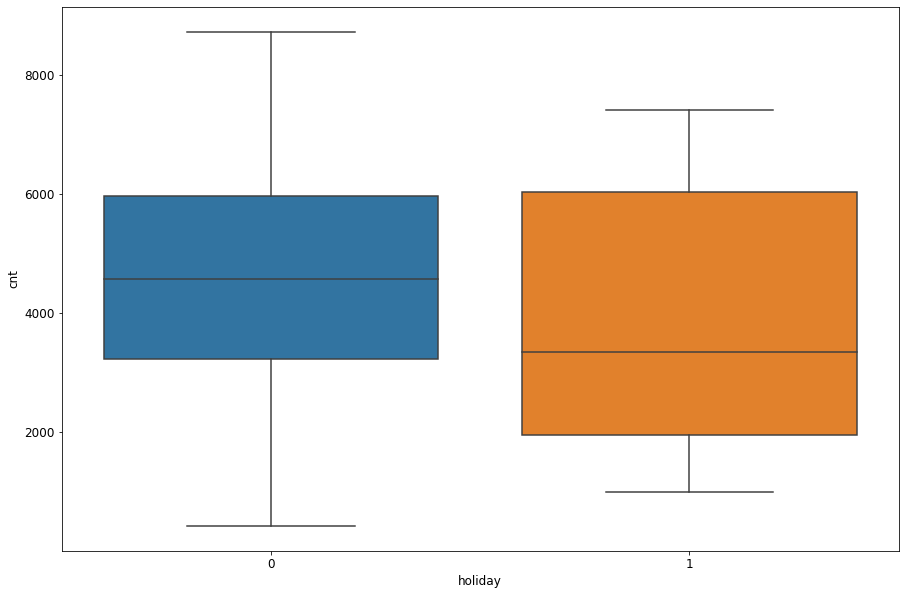

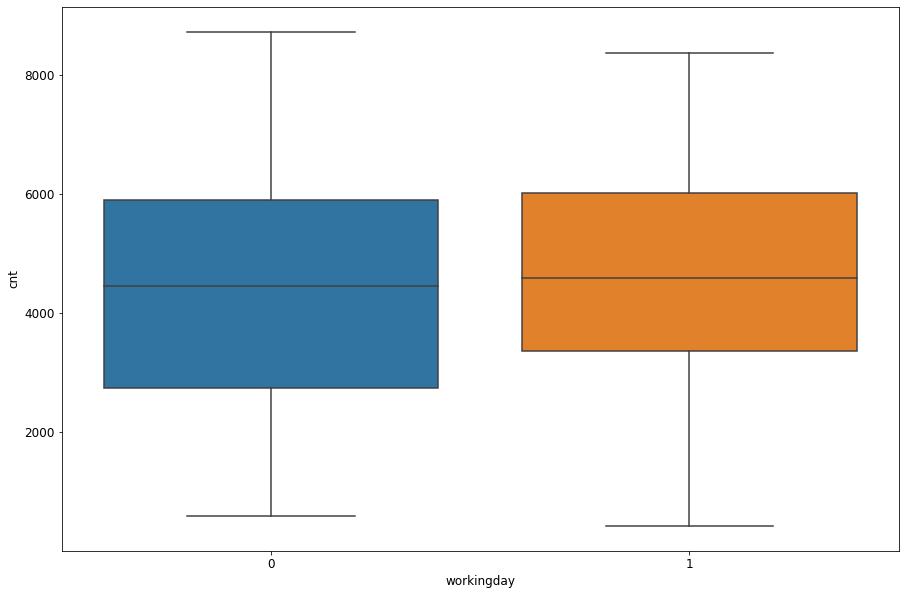

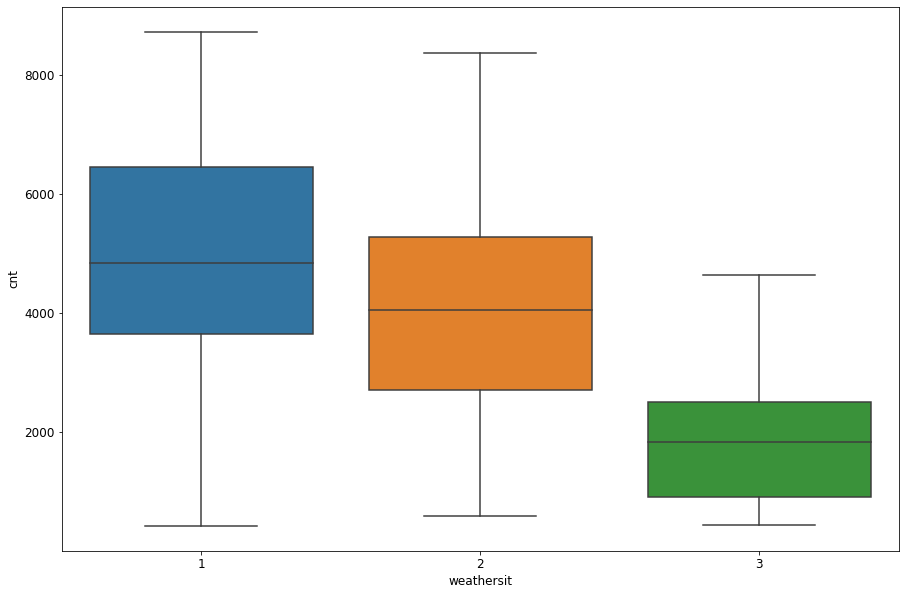

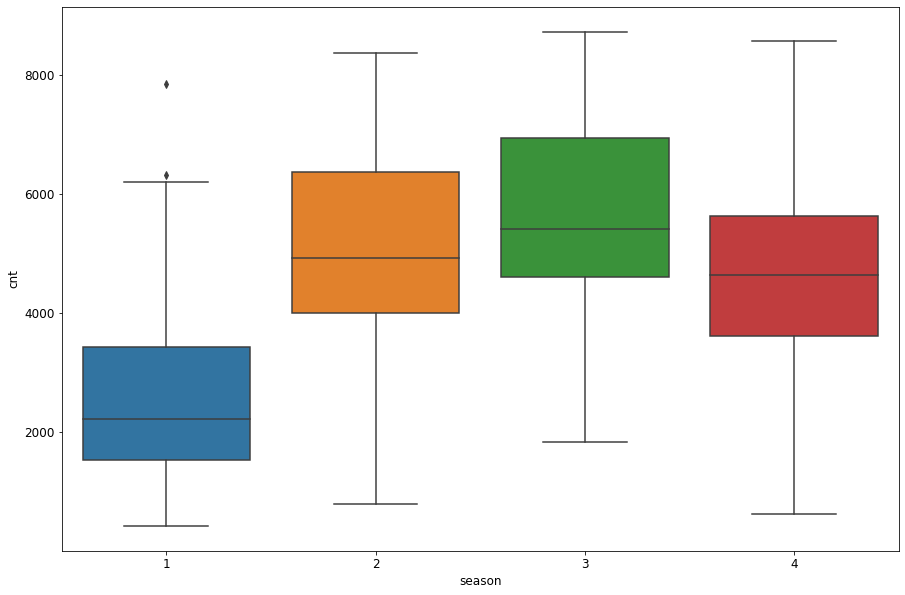

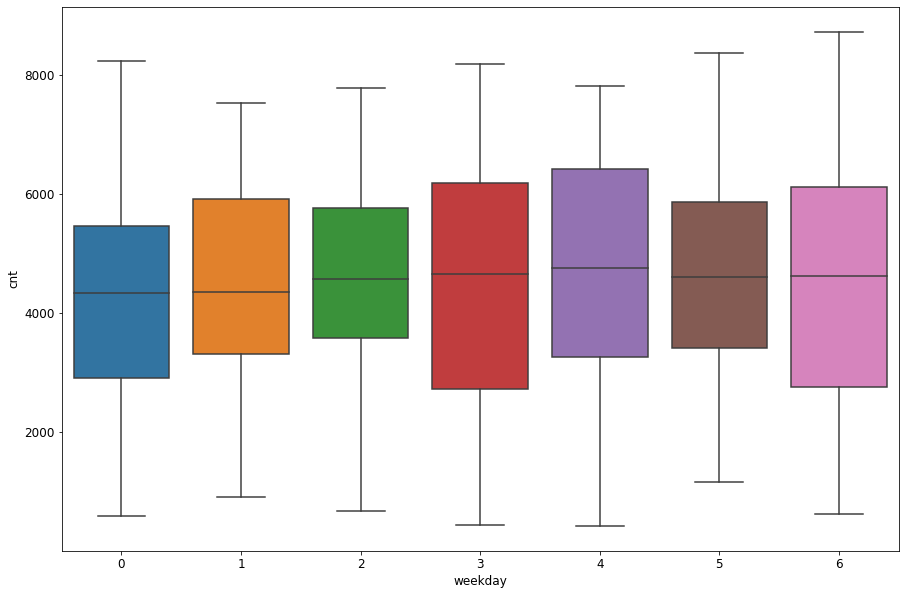

In [18]:
# Checking outliers wrt other variables and target variable
other_variables = ordered_cat + unordered_cat + ["season","weekday"]
for i in other_variables:
    eda.box_plot_cat(bike_data,i)

#### Only two outliers are found in season vs cnt plot in season 1
#### Removing those points

In [19]:

bike_data=bike_data[~((bike_data["season"]==1) & (bike_data["cnt"]>6200))]
print("The number of points remaining after removing the outliers are ",len(bike_data))


The number of points remaining after removing the outliers are  718


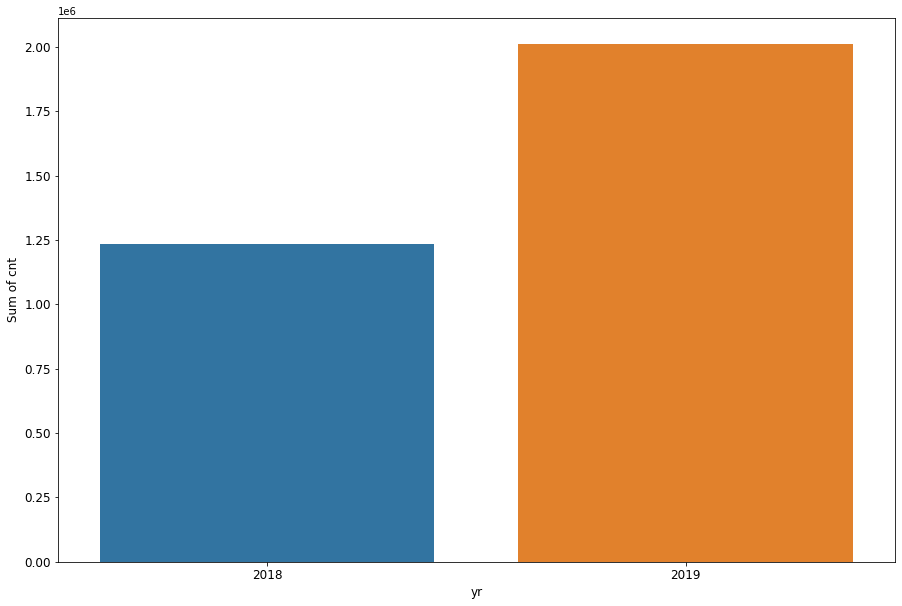

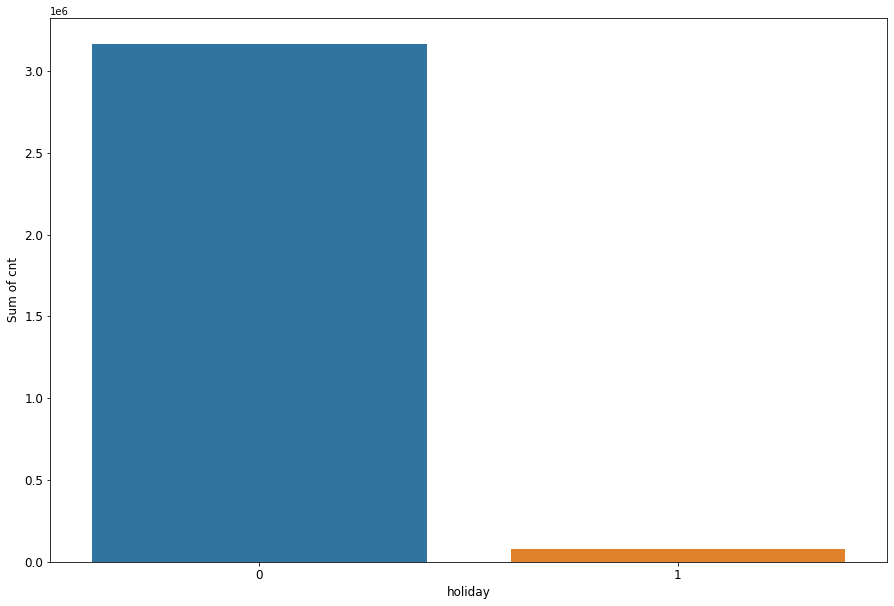

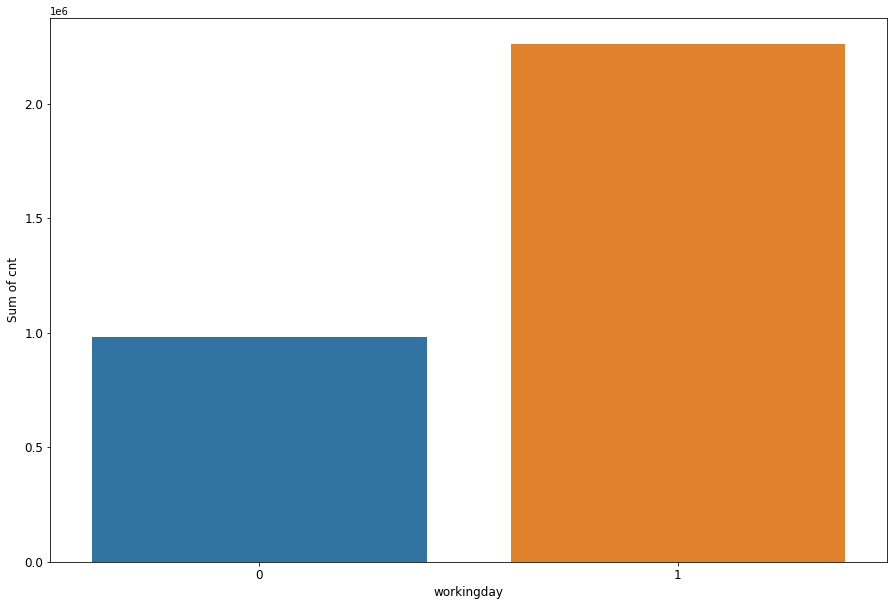

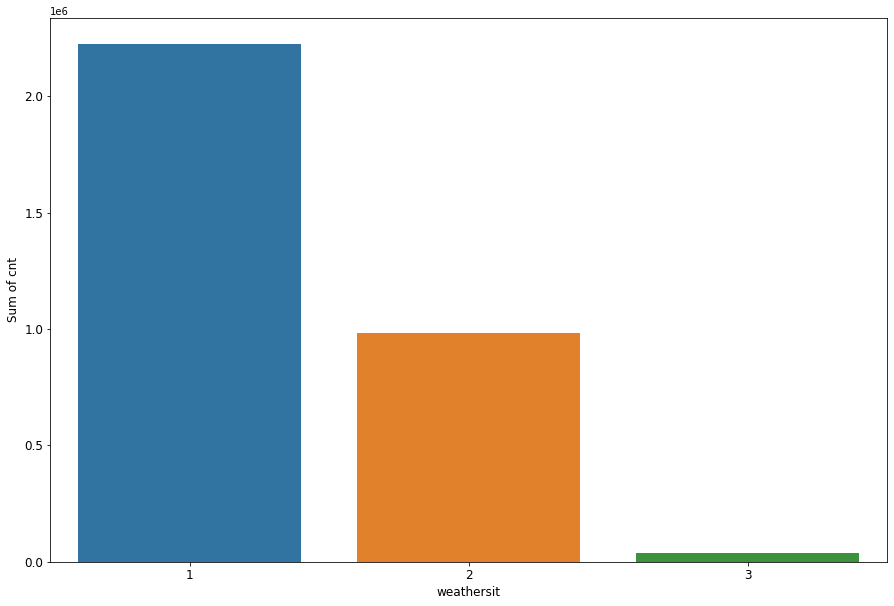

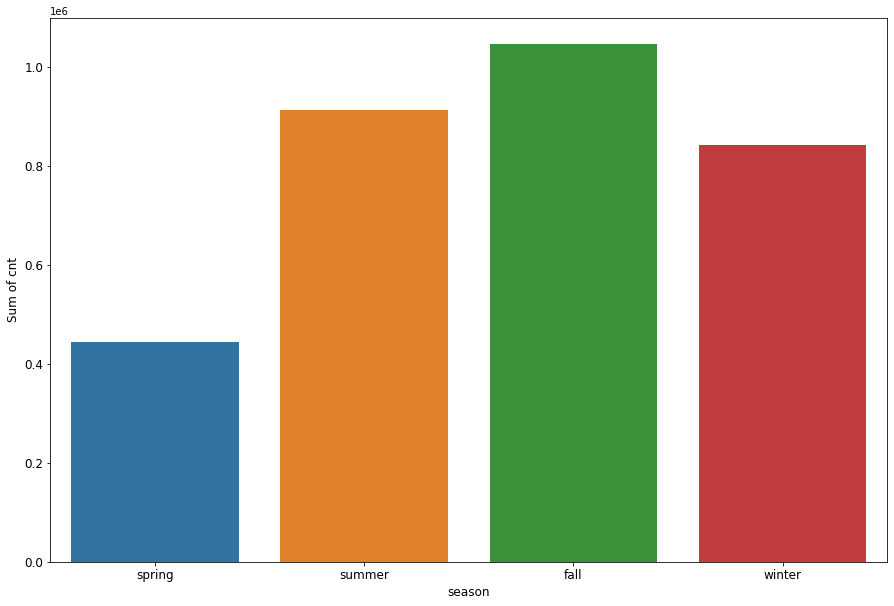

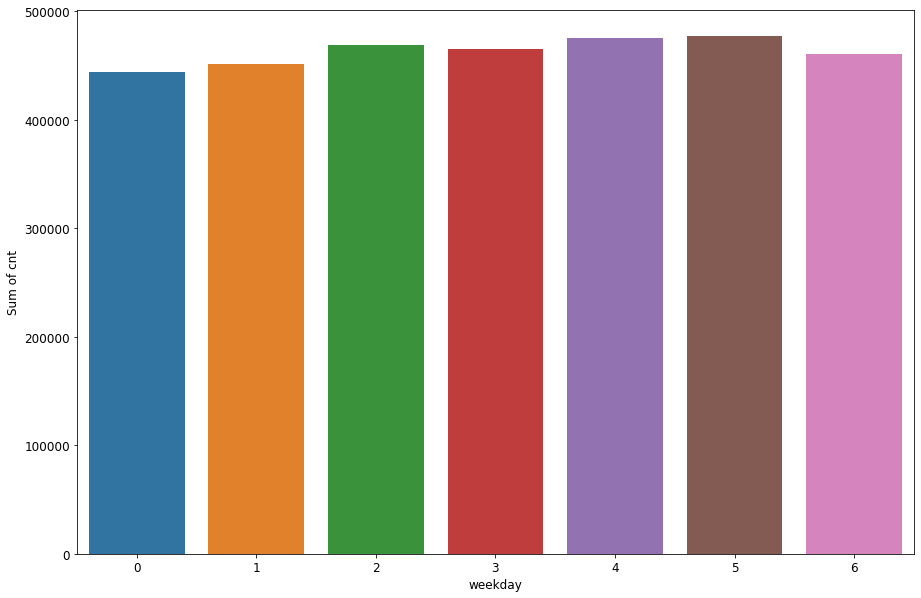

In [20]:
# Plotting bar plot wrt other variables
eda.plot_bar(bike_data,other_variables)

# Insights from EDA
1. **atemp,year and season** have high corelation with cnt - They might be the key variables in predicting the same
2. The demand of bikes has increased in 2019 compared to 2018
3. The demand of bikes is almost the same for all the weekdays - Might not contribute to cnt prediction
4. The demand is more on working days as compared to that of holidays 
5. The demand is more in clear weather conditions
6. The demand is more in fall and summer seasons

# Dealing with categorical variables
1. weekday is left as it is as it has no corelation with thhe output and might not contribute for the prediction
2. holiday and workingday are already encoded i.e 0 or 1
3. Encoding weathersit and seasons using dummy encoding

In [21]:
# Encoding weathersit
weather_enc = pd.get_dummies(bike_data["weathersit"],drop_first=True)
# Renaming the encoded columns for better understanding
weather_enc.rename(columns={2:"Mist",3:"Light_snow_rain"},inplace=True)
bike_data = pd.concat([bike_data,weather_enc],axis=1)
bike_data.drop(["weathersit"],axis=1,inplace=True)
bike_data.head()

,season,yr,holiday,weekday,workingday,atemp,hum,windspeed,cnt,Mist,Light_snow_rain
0,1,0,0,6,0,18.18125,80.5833,10.749882,985,1,0
1,1,0,0,0,0,17.68695,69.6087,16.652113,801,1,0
2,1,0,0,1,1,9.47025,43.7273,16.636703,1349,0,0
3,1,0,0,2,1,10.60610,59.0435,10.739832,1562,0,0
4,1,0,0,3,1,11.46350,43.6957,12.522300,1600,0,0


### Season is a cyclic variable and the bike sales can be high in a particular season. In order for the model to capture that this has to be encoded via dummy encoding

In [22]:
# Applying dummy encoding on column season to capture the effect of season
season_enc = pd.get_dummies(bike_data["season"],drop_first=True)
season_enc.rename(columns={2:"summer",3:"fall",4:"winter"},inplace=True)
bike_data = pd.concat([bike_data,season_enc],axis=1)
bike_data.drop(["season"],axis=1,inplace=True)
bike_data.head()

,yr,holiday,weekday,workingday,atemp,hum,windspeed,cnt,Mist,Light_snow_rain,summer,fall,winter
0,0,0,6,0,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,0,0,0,0,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,0,0,1,1,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,0,2,1,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,0,3,1,11.46350,43.6957,12.522300,1600,0,0,0,0,0


In [23]:
# # Creating a seprate df by adding a constant to inputs for capturing intercept as stat mods library doesnot have inbuit intercept built into the fit method
bike_data["cnst"] = 1

### Splitting is done before scaling to avoid data leakage
### Splitting the data for training. Using 70 % data for training and 30 % data for testing

In [24]:
X,y = bike_data.drop(("cnt"),axis=1),bike_data["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # random state is fixed to reproduce the same results

### Linear regression is independant of feature scaling
### Scaling the numerical data for better interpretation of results
### Scaling the data using min max scaler

In [25]:
feat_scal = ["atemp","hum","windspeed"]
scaler = MinMaxScaler()
X_train[feat_scal] = scaler.fit_transform(X_train[feat_scal])
X_test[feat_scal] = scaler.transform(X_test[feat_scal])

In [26]:
# Defining class for all training related methods and attributes

class Model_build:

    def __init__(self,feat): # Instance attributes
        self.feat = feat
    

    def train_model(self):
        feat_with_cnst = self.feat + ["cnst"]
        model = sm.OLS(y_train,X_train[feat_with_cnst])
        self.trained_model = model.fit()
        print(self.trained_model.summary())
        self.y_train_pred = self.trained_model.predict(X_train[feat_with_cnst])
        self.y_test_pred = self.trained_model.predict(X_test[feat_with_cnst])
        self.r2_train = round(r2_score(y_train,self.y_train_pred),3)
        self.adj_r2_train = round(self.adj_r2(self.r2_train,len(self.feat),len(y_train)),3)
        self.r2_test = round(r2_score(y_test,self.y_test_pred),3)
        self.adj_r2_test = round(self.adj_r2(self.r2_test,len(self.feat),len(y_test)),3)
        print("The r2 score on the train set is ",self.r2_train)
        print("The adjusted r2 score on the train set is ",self.adj_r2_train)
        print("The r2 score on the test set is ",self.r2_test)
        print("The adjusted r2 score on the test set is ",self.adj_r2_test)

    def adj_r2(self,r2,nfeat,n): # Method to find adjusted r2
        adjr_2 = 1-(1-r2)*(n-1)/(n-nfeat-1)
        return adjr_2

    def plot_predictions(self,actual,predicted,label_name): # Method to plot predictions
        plt.figure(figsize=(15,10))
        plt.plot(actual,actual,linewidth=3,color="green")
        plt.scatter(actual,predicted,marker="x",color="black")
        plt.legend(("Actual data","Model prediction"),fontsize=16)
        plt.xlabel("cnt",fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.title("Actual vs Model on "+ label_name + " set",fontsize=20)
        if label_name=="train":
            plt.text(1000,7000,"R2 on train set : " + str(self.r2_train),fontsize="large")
        else:
            plt.text(1000,7000,"R2 on test set : " + str(self.r2_test),fontsize="large")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_residual(self): # Method to plot
        plt.figure(figsize=(15,10))
        sns.distplot(y_train-self.y_train_pred,bins=50)
        plt.xlabel("Residual",fontsize=12)
        plt.ylabel("Density",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def calc_vif(self):
        if len(self.feat)<=1:
            print("Cannot calculate VIF as only one feature is present")
        else:
            self.vif_data = pd.DataFrame()
            self.vif_data["Features"]=self.feat
            self.vif_data["VIF_values"] =  [variance_inflation_factor(X_train[self.feat].values, i) for i in range(len(self.feat))]
            self.vif_data = self.vif_data.sort_values(by="VIF_values",ascending=False)
            print(self.vif_data)



        

In [27]:
# Building the model using bottom up approach
# The features are selected prioritizing the corelation values wrt target variables
# Creating an empty list for storing the model objects
models = [] # list for storing all model
rel_models = [] # list for storing relevant models

# Features: atemp

In [28]:
sel_feat = ["atemp"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     364.2
Date:                Sat, 07 May 2022   Prob (F-statistic):           2.10e-61
Time:                        10:18:43   Log-Likelihood:                -4362.1
No. Observations:                 502   AIC:                             8728.
Df Residuals:                     500   BIC:                             8737.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp       5506.2181    288.506     19.085      0.0

In [29]:
models[-1].calc_vif()

Cannot calculate VIF as only one feature is present


- The r2 score on the train set is  0.421
- The adjusted r2 score on the train set is  0.42
- The r2 score on the test set is  0.424
- The adjusted r2 score on the test set is  0.421
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [30]:
rel_models.append(models[-1])

# Features: atemp,yr

In [31]:
sel_feat = ["atemp","yr"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     583.6
Date:                Sat, 07 May 2022   Prob (F-statistic):          2.24e-131
Time:                        10:18:43   Log-Likelihood:                -4196.8
No. Observations:                 502   AIC:                             8400.
Df Residuals:                     499   BIC:                             8412.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp       5341.7118    207.918     25.691      0.0

In [32]:
models[-1].calc_vif()

  Features  VIF_values
0    atemp    1.830627
1       yr    1.830627


- The r2 score on the train set is  0.701
- The adjusted r2 score on the train set is  0.7
- The r2 score on the test set is  0.726
- The adjusted r2 score on the test set is  0.723
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [33]:
rel_models.append(models[-1])

# Features: atemp,yr and season (summer,fall and winter) 

In [34]:

sel_feat = ["atemp","yr","summer","fall","winter"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     324.5
Date:                Sat, 07 May 2022   Prob (F-statistic):          8.15e-154
Time:                        10:18:44   Log-Likelihood:                -4135.0
No. Observations:                 502   AIC:                             8282.
Df Residuals:                     496   BIC:                             8307.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp       4357.9231    332.112     13.122      0.0

In [35]:
models[-1].calc_vif()

  Features  VIF_values
0    atemp   11.356828
3     fall    5.680588
2   summer    3.884020
4   winter    2.494634
1       yr    1.902437


# VIF value for fall is more than 5 
# Not considering fall for further models

In [36]:
# Dropping fall as the VIF values is more than 5
sel_feat = ["atemp","yr","summer","winter"]
models.append(Model_build(sel_feat))
models[-1].train_model()


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     385.1
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.03e-150
Time:                        10:18:44   Log-Likelihood:                -4145.3
No. Observations:                 502   AIC:                             8301.
Df Residuals:                     497   BIC:                             8322.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp       5600.5285    193.903     28.883      0.0

In [37]:
models[-1].calc_vif()

  Features  VIF_values
0    atemp    2.429131
1       yr    1.870612
2   summer    1.525702
3   winter    1.292118


- The r2 score on the train set is  0.756
- The adjusted r2 score on the train set is  0.754
- The r2 score on the test set is  0.774
- The adjusted r2 score on the test set is  0.77
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [38]:
rel_models.append(models[-1])

# Features: atemp,yr,season(summer, winter) and weather (Mist,Light_snow_rain)

In [39]:

sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain"]
models.append(Model_build(sel_feat))
models[-1].train_model()


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     337.2
Date:                Sat, 07 May 2022   Prob (F-statistic):          2.84e-171
Time:                        10:18:44   Log-Likelihood:                -4091.1
No. Observations:                 502   AIC:                             8196.
Df Residuals:                     495   BIC:                             8226.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5399.2113    175.393     

In [40]:
models[-1].calc_vif()

          Features  VIF_values
0            atemp    2.548319
1               yr    1.894675
2           summer    1.545999
4             Mist    1.433216
3           winter    1.351643
5  Light_snow_rain    1.022475


- The r2 score on the train set is  0.803
- The adjusted r2 score on the train set is  0.801
- The r2 score on the test set is  0.814
- The adjusted r2 score on the test set is  0.809
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [41]:
rel_models.append(models[-1])

# Features: atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) and windspeed

In [42]:

sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain","windspeed"]
models.append(Model_build(sel_feat))
models[-1].train_model()


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     296.9
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.71e-172
Time:                        10:18:44   Log-Likelihood:                -4085.3
No. Observations:                 502   AIC:                             8187.
Df Residuals:                     494   BIC:                             8220.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5242.2336    179.500     

In [43]:
models[-1].calc_vif()

          Features  VIF_values
0            atemp    3.605349
6        windspeed    3.453686
1               yr    1.987175
2           summer    1.589248
4             Mist    1.456176
3           winter    1.383156
5  Light_snow_rain    1.053719


- The r2 score on the train set is  0.808
- The adjusted r2 score on the train set is  0.805
- The r2 score on the test set is  0.819
- The adjusted r2 score on the test set is  0.813
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [44]:
rel_models.append(models[-1])

# Features:  atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) , windspeed and hum

In [45]:
sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain","windspeed","hum"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     267.8
Date:                Sat, 07 May 2022   Prob (F-statistic):          4.80e-174
Time:                        10:18:45   Log-Likelihood:                -4078.7
No. Observations:                 502   AIC:                             8175.
Df Residuals:                     493   BIC:                             8213.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5420.9035    184.070     

In [46]:
models[-1].calc_vif()

          Features  VIF_values
7              hum   10.107171
0            atemp    6.916280
6        windspeed    3.606956
4             Mist    2.290281
1               yr    1.988490
2           summer    1.590772
3           winter    1.552763
5  Light_snow_rain    1.275329


# VIF value for hum is more than 5 
# Not considering hum for further models

# Features:  atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) , windspeed and holiday

In [47]:
sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain","windspeed","holiday"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     274.3
Date:                Sat, 07 May 2022   Prob (F-statistic):          3.87e-176
Time:                        10:18:45   Log-Likelihood:                -4073.8
No. Observations:                 502   AIC:                             8166.
Df Residuals:                     493   BIC:                             8203.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5197.0302    175.859     

In [48]:
models[-1].calc_vif()

          Features  VIF_values
0            atemp    3.605458
6        windspeed    3.481863
1               yr    1.987179
2           summer    1.589296
4             Mist    1.457225
3           winter    1.386006
5  Light_snow_rain    1.055158
7          holiday    1.035936


- The r2 score on the train set is  0.817
- The adjusted r2 score on the train set is  0.814
- The r2 score on the test set is  0.811
- The adjusted r2 score on the test set is  0.804
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [49]:
rel_models.append(models[-1])

# Features:  atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) , windspeed, holiday and weekday

In [50]:
sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain","windspeed","holiday","weekday"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     254.6
Date:                Sat, 07 May 2022   Prob (F-statistic):          7.82e-179
Time:                        10:18:45   Log-Likelihood:                -4064.5
No. Observations:                 502   AIC:                             8149.
Df Residuals:                     492   BIC:                             8191.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5208.7263    172.843     

In [51]:
models[-1].calc_vif()

          Features  VIF_values
0            atemp    4.081891
6        windspeed    3.875663
8          weekday    2.956175
1               yr    1.996451
2           summer    1.590267
4             Mist    1.463519
3           winter    1.399511
5  Light_snow_rain    1.056341
7          holiday    1.042034


- The r2 score on the train set is  0.823
- The adjusted r2 score on the train set is  0.82
- The r2 score on the test set is  0.816
- The adjusted r2 score on the test set is  0.808
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [52]:
rel_models.append(models[-1])

# Features: atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) , windspeed, holiday ,weekday and working day

In [53]:
sel_feat = ["atemp","yr","summer","winter","Mist","Light_snow_rain","windspeed","holiday","weekday","workingday"]
models.append(Model_build(sel_feat))
models[-1].train_model()

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     231.2
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.33e-178
Time:                        10:18:45   Log-Likelihood:                -4062.2
No. Observations:                 502   AIC:                             8146.
Df Residuals:                     491   BIC:                             8193.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
atemp            5183.4630    172.622     

In [54]:
models[-1].calc_vif()

          Features  VIF_values
0            atemp    4.669841
6        windspeed    4.088705
9       workingday    3.162432
8          weekday    2.979541
1               yr    1.997164
2           summer    1.591172
4             Mist    1.498630
3           winter    1.409692
7          holiday    1.100301
5  Light_snow_rain    1.056458


- The r2 score on the train set is  0.825
- The adjusted r2 score on the train set is  0.821
- The r2 score on the test set is  0.815
- The adjusted r2 score on the test set is  0.806
- VIF values for all the features less than 5
- All the **features are significant** pvalues less than 0.05
- **Model is significant** - f score less than 0.05

In [55]:
rel_models.append(models[-1])

# Final model metrics
## Relevant features : atemp,yr,season(summer, winter), weather (Mist,Light_snow_rain) , windspeed, holiday ,weekday and working day
## R2 on train set : 0.825
## R2 on test set : 0.815

# Validating the assumptions of linear regression

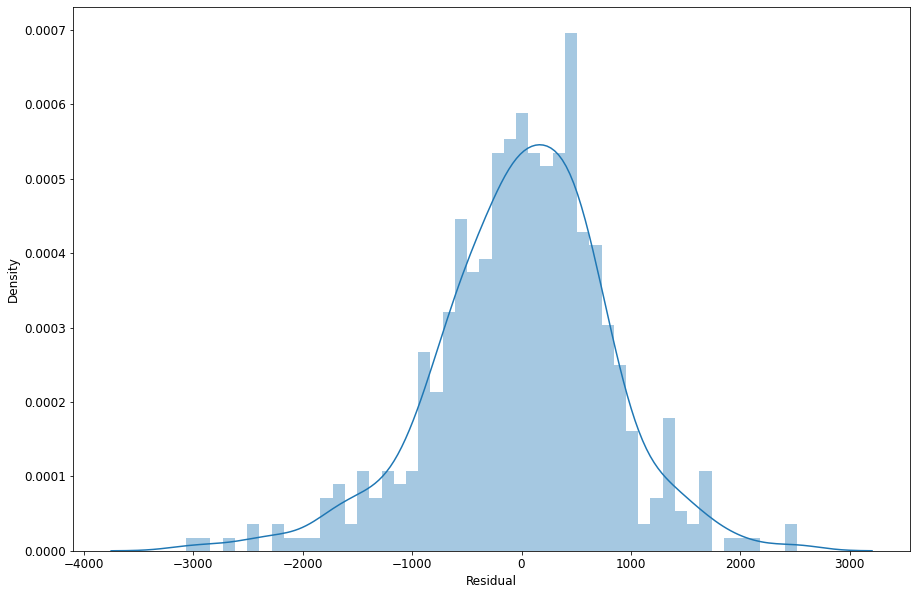

In [56]:
# Plotting dist plot of residuals for the final model
rel_models[-1].plot_residual()

### From the above graph we can see that the residuals have a mean of value almost close to 0 and are normally distributed

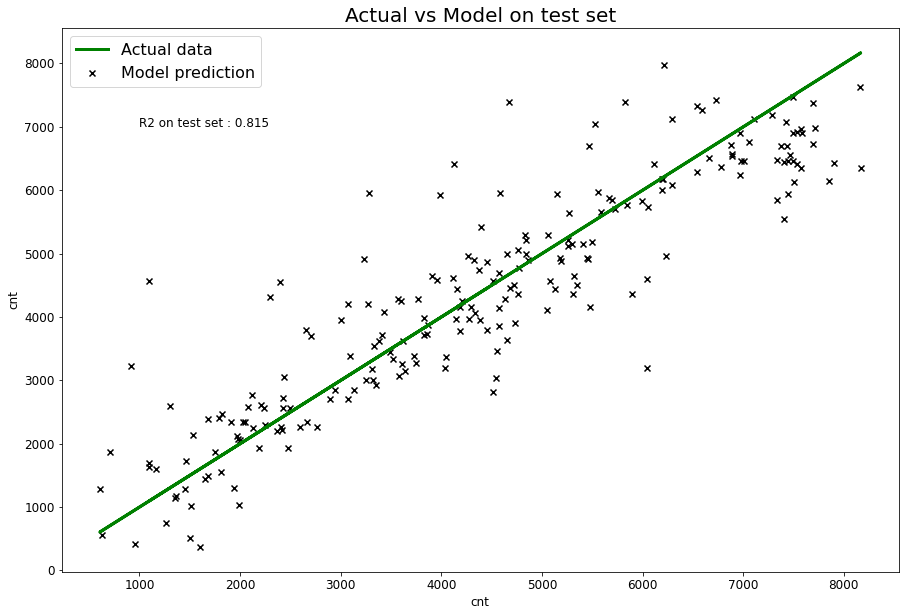

In [57]:
# Plotting the predictions on test set
rel_models[-1].plot_predictions(y_test,rel_models[-1].y_test_pred,"test")

- The model is able to explaing around 81 percentage of variance on both train and test sets

- Final model coefficients are

In [58]:
print(rel_models[-1].trained_model.params.round(2))

atemp              5183.46
yr                 2006.74
summer              648.37
winter             1135.77
Mist               -706.70
Light_snow_rain   -2030.38
windspeed          -692.29
holiday            -760.40
weekday              77.96
workingday          171.78
cnst                492.02
dtype: float64


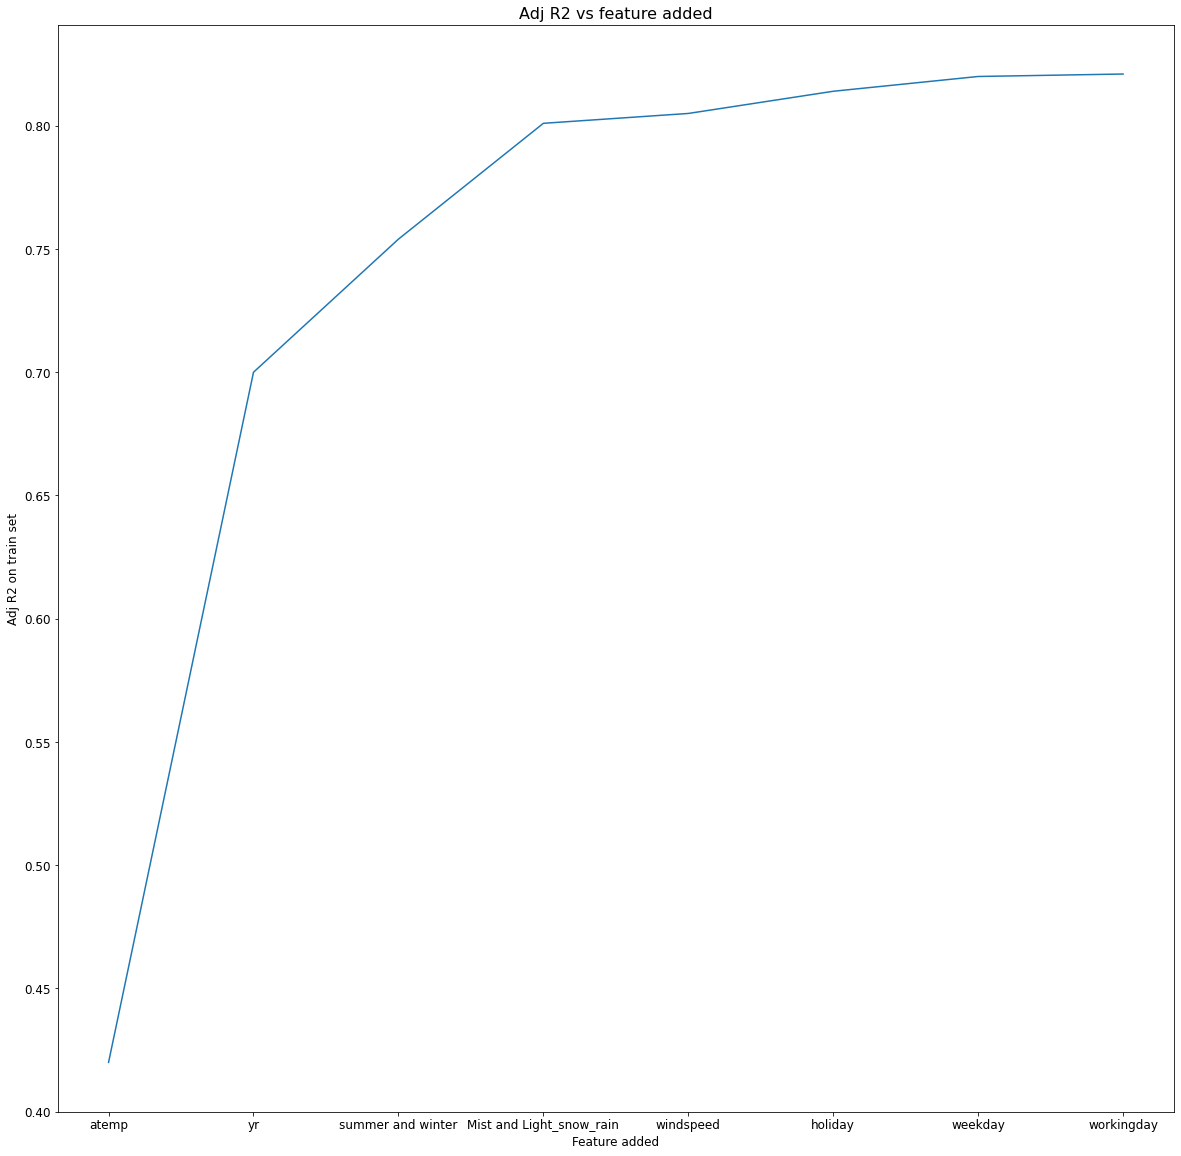

In [59]:
# Plotting adj r2 for all the relevant models
plt.figure(figsize=(20,20))
x_pos = [i for i in range(1,len(rel_models)+1)]
plt.plot(x_pos,[j.adj_r2_train for j in rel_models])
feature_added_list  = ["atemp","yr","summer and winter","Mist and Light_snow_rain","windspeed","holiday","weekday","workingday"]
plt.xticks(x_pos,feature_added_list,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Feature added",fontsize=12)
plt.ylabel("Adj R2 on train set",fontsize=12)
plt.title("Adj R2 vs feature added",fontsize=16)
plt.show()

# Conclusion
- We were able to explain about 81% of variance
- The model is generalizing well on unseen data
# Important features in order: 
    - positive impact:
        - atemp,yr,summer,winter,weekday,workingday
    - negative impact:
        - Mist,Light_snow_rain,windspeed,holiday



# Further improvements to the model can be done by
1. Using complex model
2. For higher values of cnt the model is underpredicting and for the cnt in the range of 0 to 2000 the variance is more. From this we can say that the linear model is not able to properly capture the relation in this range.
3. Enusring identical distibution on test and train sets